In [1]:
import numpy as np
import pandas as pd
import torch
import random
from collections import Counter

import seaborn as sns 
from sklearn.semi_supervised import LabelPropagation
from sklearn.semi_supervised import LabelSpreading
from sklearn.cluster import KMeans
from sklearn.metrics.cluster import adjusted_mutual_info_score
from sklearn.metrics.cluster import adjusted_rand_score

## Load SmartContract dataset

In [2]:
cd /content/drive/MyDrive/MIE8888/Smart Contract/

/content/drive/MyDrive/MIE8888/Smart Contract


In [3]:
vectors = torch.load("vectors.pt", map_location=torch.device('cpu')).detach().cpu().numpy()
targets = torch.load("labels.pt", map_location=torch.device('cpu')).detach().cpu().numpy().reshape(-1,)
print(vectors.shape)
print(targets.shape)

(22443, 256)
(22443,)


In [4]:
len(Counter(targets))

90

In [5]:
df = pd.DataFrame(vectors)
df['class'] = targets

In [14]:
df

,0,1,2,3,4,5,6,7,8,9,...,247,248,249,250,251,252,253,254,255,class
0,0.111661,0.034962,0.025885,0.000000,0.0,0.0,0.079101,0.000000,0.048922,0.086890,...,0.694713,0.589244,0.415348,0.021515,0.247651,0.131002,0.075833,0.0,0.108983,1.0
1,0.111661,0.034962,0.025885,0.000000,0.0,0.0,0.079101,0.000000,0.048922,0.086890,...,0.694713,0.589244,0.415348,0.021515,0.247651,0.131002,0.075833,0.0,0.108983,1.0
2,0.111661,0.034962,0.025885,0.000000,0.0,0.0,0.079101,0.000000,0.048922,0.077186,...,0.694713,0.589244,0.415348,0.024312,0.247651,0.124732,0.075833,0.0,0.108983,1.0
3,0.111661,0.034962,0.025885,0.000000,0.0,0.0,0.079101,0.000000,0.048922,0.086890,...,0.694713,0.589244,0.415348,0.021515,0.247651,0.131002,0.075833,0.0,0.108983,1.0
4,0.111661,0.034962,0.025885,0.000000,0.0,0.0,0.079101,0.000000,0.048922,0.086890,...,0.694713,0.589244,0.415348,0.021515,0.247651,0.131002,0.075833,0.0,0.108983,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
22438,0.288664,0.105290,0.038769,0.010645,0.0,0.0,0.095868,0.018392,0.054183,0.293962,...,0.902067,0.498535,0.034602,0.020090,0.492734,0.338706,0.408384,0.0,0.273504,118.0
22439,0.266739,0.058343,0.026502,0.000000,0.0,0.0,0.067846,0.000000,0.025188,0.317354,...,0.609337,0.295497,0.021530,0.010989,0.102226,0.160206,0.187483,0.0,0.273742,118.0
22440,0.266739,0.058343,0.026502,0.000000,0.0,0.0,0.046085,0.000000,0.025188,0.317354,...,0.715197,0.341643,0.018123,0.009803,0.119310,0.160206,0.187483,0.0,0.273742,118.0
22441,0.266739,0.058343,0.026502,0.000000,0.0,0.0,0.067846,0.000000,0.025188,0.317354,...,0.609337,0.295497,0.021530,0.010989,0.102226,0.160206,0.187483,0.0,0.273742,118.0


## Label propagation 

In [7]:
def label_propagation(model, df, labeled):
  
  X = df.iloc[:,:-1].values
  y = df.iloc[:,-1].values
  train_labels = np.copy(y)

  y_count = np.unique(y, return_counts=True)[1]
  random_unlabeled_points = []
  for i in y_count:
    temp = list(np.random.rand(i) < 1-labeled)
    while False not in temp:   #### Make sure at least one label in each class
      temp = list(np.random.rand(i) < 1-labeled)
    random_unlabeled_points.extend(temp)

  random_unlabeled_points = np.array(random_unlabeled_points)
  train_labels[random_unlabeled_points] = -1

  model.fit(X, train_labels)
  prediction = model.predict(X[random_unlabeled_points])
  y_true = y[random_unlabeled_points]

  return adjusted_rand_score(y_true, prediction), adjusted_mutual_info_score(y_true, prediction)

### Sanity check on subset

In [8]:
def sub_dataset(df, number_of_classes):
  classes = random.choices(pd.unique(df['class']),k=number_of_classes)

  subset = df.loc[df['class'].isin(classes)].reset_index(drop=True)

  return subset

In [ ]:
subset = sub_dataset(df, 10)
output = []
iteration = 10
labeled_list = [0.005, 0.01, 0.05, 0.1]
models = [LabelSpreading()]
for i in range(iteration):
  for model in models:
    for labeled_percent in labeled_list:
      ari, ami = label_propagation(model, subset, labeled_percent)
      output.append([i, model, labeled_percent, ari, ami])

### Run on K-Means
kmeans = KMeans(n_clusters=10, random_state=1).fit(subset.iloc[:,:-1].values)
kmeans_ari = adjusted_rand_score(subset.iloc[:,-1].values,kmeans.labels_)
kmeans_ami = adjusted_mutual_info_score(subset.iloc[:,-1].values,kmeans.labels_)
output.append([0,"K-Means",0, kmeans_ari, kmeans_ari])
output.append([0,"K-Means",0.1, kmeans_ari, kmeans_ari])

result = pd.DataFrame(output, columns=["Iteration", "Model", "Labeled Population", "ARI", "AMI"])

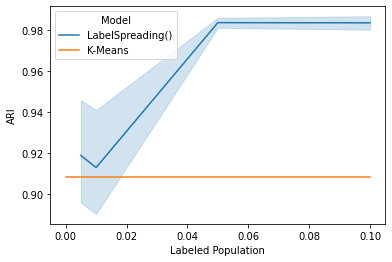

In [ ]:
sns.lineplot(data=result,x='Labeled Population', y='ARI', hue="Model")

### Label Propagation

In [ ]:
label_propagation(LabelSpreading(), df, 0.1)
### about 1min

(0.9035086686362873, 0.9540360470576055)

In [ ]:
label_propagation(LabelPropagation(), df, 0.1)
### more than 1h20min

/usr/local/lib/python3.7/dist-packages/sklearn/semi_supervised/_label_propagation.py:318: ConvergenceWarning: max_iter=1000 was reached without convergence.
  category=ConvergenceWarning,


(0.8959532058205337, 0.9514791797514391)

In [ ]:
output = []
iteration = 10
labeled_list = [0.005, 0.01, 0.05, 0.1]
models = [LabelSpreading()]
for i in range(iteration):
  for model in models:
    for labeled_percent in labeled_list:
      ari, ami = label_propagation(model, df, labeled_percent)
      output.append([i, model, labeled_percent, ari, ami])

### Run on K-Means
kmeans = KMeans(n_clusters=90, random_state=1).fit(df.iloc[:,:-1].values)
kmeans_ari = adjusted_rand_score(df.iloc[:,-1].values,kmeans.labels_)
kmeans_ami = adjusted_mutual_info_score(df.iloc[:,-1].values,kmeans.labels_)
output.append([0,"K-Means",0, kmeans_ari, kmeans_ari])
output.append([0,"K-Means",0.1, kmeans_ari, kmeans_ari])

result = pd.DataFrame(output, columns=["Iteration", "Model", "Labeled Population", "ARI", "AMI"])

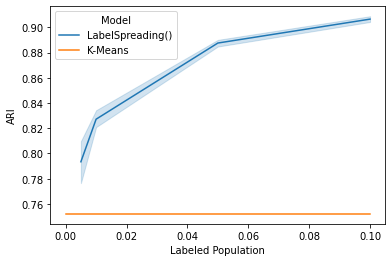

In [ ]:
sns.lineplot(data=result,x='Labeled Population', y='ARI', hue="Model")

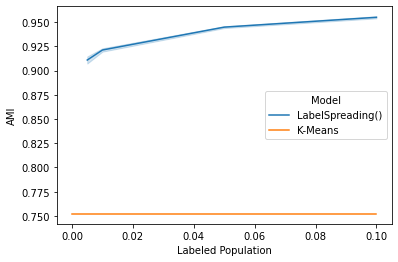

In [ ]:
sns.lineplot(data=result,x='Labeled Population', y='AMI', hue="Model")

## Active Learning

In [17]:
def active_learning(df, labeled, num_increment, max_iteration):
  X = df.iloc[:,:-1].values
  y = df.iloc[:,-1].values
  output = []
  y_count = np.unique(y, return_counts=True)[1]

  ##query 1% every iteration
  query_num = int(X.shape[0]*0.01)

  for iteration in range(max_iteration):
    ### Create initial training labels
    model = LabelSpreading()
    unlabeled_indices = []
    for i in y_count:
      temp = list(np.random.rand(i) < 1-labeled)
      while False not in temp:   #### Make sure at least one label in each class
        temp = list(np.random.rand(i) < 1-labeled)
      unlabeled_indices.extend(temp)
    unlabeled_indices = np.array(unlabeled_indices)

    for j in range(num_increment):
      train_labels = np.copy(y)
      print("This is iteration {} with {} unlabeled instances".format(iteration,np.sum(unlabeled_indices)))
      train_labels[unlabeled_indices] = -1
      model.fit(X, train_labels)
      prediction = model.predict(X[unlabeled_indices])
      ari = adjusted_rand_score(y[unlabeled_indices], prediction)
      ami = adjusted_mutual_info_score(y[unlabeled_indices], prediction)
      output.append([i, model, labeled+j*0.01, "Yes", ari, ami])
      ### Query least confidence instances
      predict_prob = model.predict_proba(X[unlabeled_indices])
      max_prob = np.amax(predict_prob, axis=1)
      unlabeled_indices[np.argsort(max_prob)[:query_num]] = False
  return output

In [ ]:
output = active_learning(df, labeled=0.01, num_increment=10, max_iteration=5)

This is iteration 0 with 22186 unlabeled instances
This is iteration 0 with 21963 unlabeled instances
This is iteration 0 with 21740 unlabeled instances
This is iteration 0 with 21525 unlabeled instances
This is iteration 0 with 21316 unlabeled instances
This is iteration 0 with 21110 unlabeled instances
This is iteration 0 with 20899 unlabeled instances
This is iteration 0 with 20697 unlabeled instances
This is iteration 0 with 20480 unlabeled instances
This is iteration 0 with 20298 unlabeled instances
This is iteration 1 with 22207 unlabeled instances
This is iteration 1 with 21986 unlabeled instances
This is iteration 1 with 21776 unlabeled instances
This is iteration 1 with 21583 unlabeled instances
This is iteration 1 with 21375 unlabeled instances
This is iteration 1 with 21166 unlabeled instances
This is iteration 1 with 20949 unlabeled instances
This is iteration 1 with 20742 unlabeled instances
This is iteration 1 with 20522 unlabeled instances
This is iteration 1 with 20334 

In [18]:
result = pd.DataFrame(output, columns=["Iteration", "Model", "Labeled Population", "Active Learning", "ARI", "AMI"])

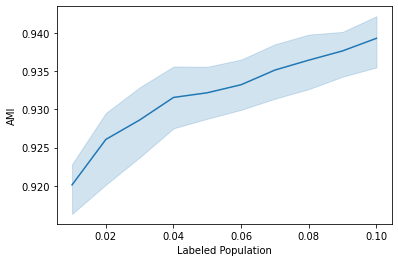

In [19]:
sns.lineplot(data=result,x='Labeled Population', y='AMI')

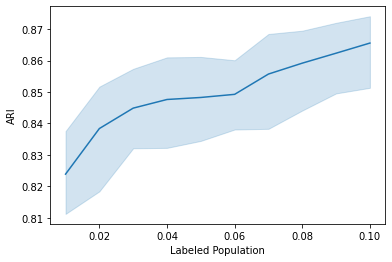

In [20]:
sns.lineplot(data=result,x='Labeled Population', y='ARI')

In [23]:
output2 = output.copy()
iteration = 5
labeled_list = [0.01, 0.02, 0.03, 0.04, 0.05, 0.06, 0.07, 0.08, 0.09, 0.1]
models = [LabelSpreading()]
for i in range(iteration):
  for model in models:
    for labeled_percent in labeled_list:
      ari, ami = label_propagation(model, df, labeled_percent)
      output2.append([i, model, labeled_percent, "No", ari, ami])

In [ ]:
### Run on K-Means
kmeans = KMeans(n_clusters=90, random_state=1).fit(df.iloc[:,:-1].values)
kmeans_ari = adjusted_rand_score(df.iloc[:,-1].values,kmeans.labels_)
kmeans_ami = adjusted_mutual_info_score(df.iloc[:,-1].values,kmeans.labels_)
output2.append([0,"K-Means",0, "No", kmeans_ari, kmeans_ari])
output2.append([0,"K-Means",0.1, "No", kmeans_ari, kmeans_ari])

In [35]:
final_result = pd.DataFrame(output2, columns=["Iteration", "Model", "Labeled Population", "Active Learning", "ARI", "AMI"])

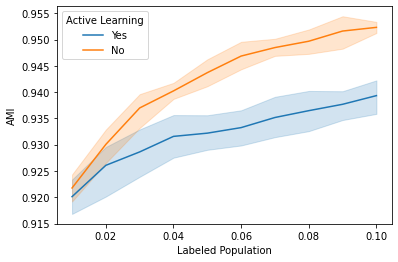

In [37]:
sns.lineplot(data=final_result,x='Labeled Population', y='AMI', hue="Active Learning")

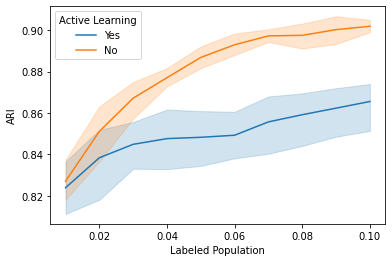

In [38]:
sns.lineplot(data=final_result,x='Labeled Population', y='ARI', hue="Active Learning")